# The Numerical Sandbox: Compression Experiment (Moving Wall)

**Romain Beucher**
Version 0.1

In [1]:
import UWGeodynamics as GEO
import glucifer

loaded rc file /workspace/user_data/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.u

## Scaling

In [3]:
velocity = 2.5 * u.centimeter / u.hour
model_length = 40. * u.centimeter
model_height = 10. * u.centimeter
refViscosity = 1e7 * u.pascal * u.second
bodyforce = 1560 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

# General parameters

In [4]:
Model = GEO.Model(elementRes=(200,50), 
                  minCoord=(0. * u.centimeter, -3.5 * u.centimeter), 
                  maxCoord=(40. * u.centimeter, 6.5 * u.centimeter))

In [6]:
Model.outputDir="outputs_tutorial_IndentorB"

In [7]:
Model.minViscosity = 1.0e5 * u.pascal * u.second
Model.maxViscosity = 1e12 * u.pascal * u.second

# Initial Setup

# Model Geometry

The shortening experiment follows a more or less classic set-up used to study fold-and-thrust belt evolution with analogue models. Shortening is achieved by moving the right-hand wall inward while the left wall and base are held fixed. The model consists of ‘sand’ layers with an embedded 0.5 cm thick layer of weaker ‘microbeads'. Total height is 10 cm. The initial width of the model is 40 cm. At the right side an initial wedge 10 cm long with a 10 degrees surface slope overlies the model. This wedge slope is in the stable field for a sand wedge (as calculated for this set-up from Dahlen 1984; Zhao et al. 1986). The

We use a uniform resolution of 0.2 cm (400 x 100 elements)


## Material distribution

The way we choose do define the initial set up is based on the distribution of the different materials (or phases).

In [8]:
air        = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=0.0))
sand1      = Model.add_material(name="Sand1", shape=GEO.shapes.Layer(top=air.bottom, bottom=Model.bottom))
sand2      = Model.add_material(name="Sand2", shape=GEO.shapes.Layer(top=-1.0 * u.centimetre, bottom=-1.5*u.centimetre))
microbeads = Model.add_material(name="Microbeads", shape=GEO.shapes.Layer(top=-2.5 * u.centimetre, bottom=-3.0*u.centimetre))

import numpy as np

wedge = [( 30.* u.centimeter, 0. * u.centimeter),
         (Model.maxCoord[0], 10.*u.centimeter * np.tan(np.radians(10))),
         (Model.maxCoord[0], 0. * u.centimeter)]

sand3     = Model.add_material(name="Sand3", shape=GEO.shapes.Polygon(wedge))

## Passive Tracers

In [9]:
import numpy as np

x = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), 1000)
interface1 = GEO.nd(sand1.top)
interface2 = GEO.nd(sand2.top)
interface3 = GEO.nd(sand2.bottom)
interface4 = GEO.nd(microbeads.top)
interface5 = GEO.nd(microbeads.bottom)

interface1 = Model.add_passive_tracers(name="Interface1", vertices=[x, interface1])
interface2 = Model.add_passive_tracers(name="Interface2", vertices=[x, interface2])
interface3 = Model.add_passive_tracers(name="Interface3", vertices=[x, interface3])
interface4 = Model.add_passive_tracers(name="Interface4", vertices=[x, interface4])
interface5 = Model.add_passive_tracers(name="Interface5", vertices=[x, interface5])


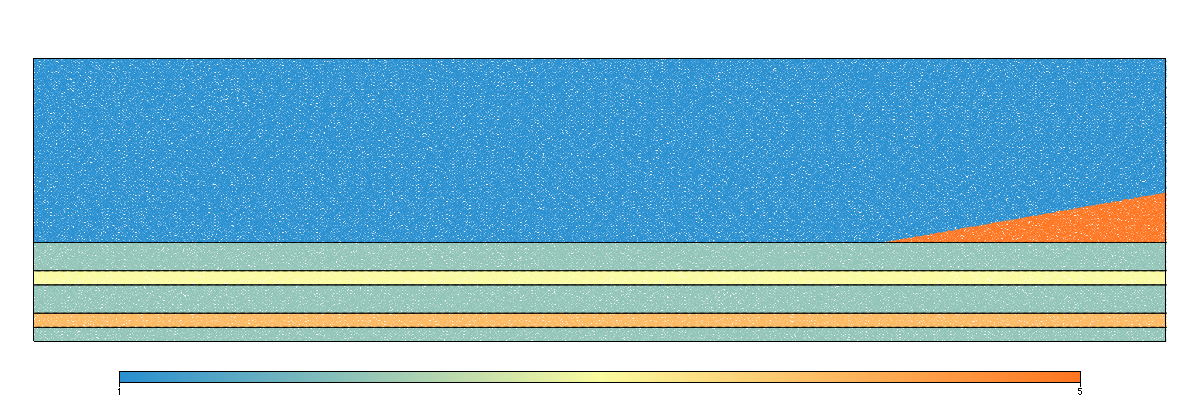

In [10]:
import glucifer
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(interface1.swarm, pointSize=2.0)
Fig.Points(interface2.swarm, pointSize=2.0)
Fig.Points(interface3.swarm, pointSize=2.0)
Fig.Points(interface4.swarm, pointSize=2.0)
Fig.Points(interface5.swarm, pointSize=2.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()

## Material properties

### Densities

In [11]:
air.density        = 10. * u.kilogram / u.metre**3
sand1.density      = 1560. * u.kilogram / u.metre**3
sand2.density      = 1560. * u.kilogram / u.metre**3
sand3.density      = 1560. * u.kilogram / u.metre**3
microbeads.density = 1480. * u.kilogram / u.metre**3

## Viscosities

In [12]:
air.viscosity        = 1.0e5 * u.pascal * u.second
sand1.viscosity      = 1.0e12 * u.pascal * u.second
sand2.viscosity      = 1.0e12 * u.pascal * u.second
sand3.viscosity      = 1.0e12 * u.pascal * u.second
microbeads.viscosity = 1.0e12 * u.pascal * u.second

## Plasticities

In [13]:
sandFriction = np.tan(np.radians(36.0))
sandFrictionW = np.tan(np.radians(31.0))

microbeadsFriction = np.tan(np.radians(22.0))
microbeadsFrictionW = np.tan(np.radians(21.0))

sand1.plasticity       = GEO.DruckerPrager(cohesion=10.*u.pascal, frictionCoefficient=sandFriction, frictionAfterSoftening=sandFrictionW)
sand2.plasticity       = GEO.DruckerPrager(cohesion=10.*u.pascal, frictionCoefficient=sandFriction, frictionAfterSoftening=sandFrictionW)
sand3.plasticity       = GEO.DruckerPrager(cohesion=10.*u.pascal, frictionCoefficient=sandFriction, frictionAfterSoftening=sandFrictionW)
microbeads.plasticity  = GEO.DruckerPrager(cohesion=10.*u.pascal, frictionCoefficient=microbeadsFriction, frictionAfterSoftening=microbeadsFrictionW)

In [15]:
Model.set_velocityBCs(left=[0.,0.], right=GEO.MovingWall(velocity=-2.5 * u.centimetre / u.hour), bottom=[None,0.])

In [16]:
Model.init_model()

In [18]:
GEO.rcParams["solver"] = "mumps"
GEO.rcParams["penalty"] = 1e6

In [ ]:
Model.run_for(nstep=6.0 * u.hours, checkpoint_interval=5. * u.minutes)

Running with UWGeodynamics version 0.9.8b-dev-f728b34(master)
Step:1 Model Time:  1.16008250759e-06 year dt: 1.16008250759e-06 year (2018-11-19 06:56:46)
Step:2 Model Time:  4.38006554932e-06 year dt: 3.21998304173e-06 year (2018-11-19 06:57:23)
Finalising Model


In [ ]:
import glucifer
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(interface1.swarm, pointSize=2.0)
Fig.Points(interface2.swarm, pointSize=2.0)
Fig.Points(interface3.swarm, pointSize=2.0)
Fig.Points(interface4.swarm, pointSize=2.0)
Fig.Points(interface5.swarm, pointSize=2.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=3.0)
Fig.show()


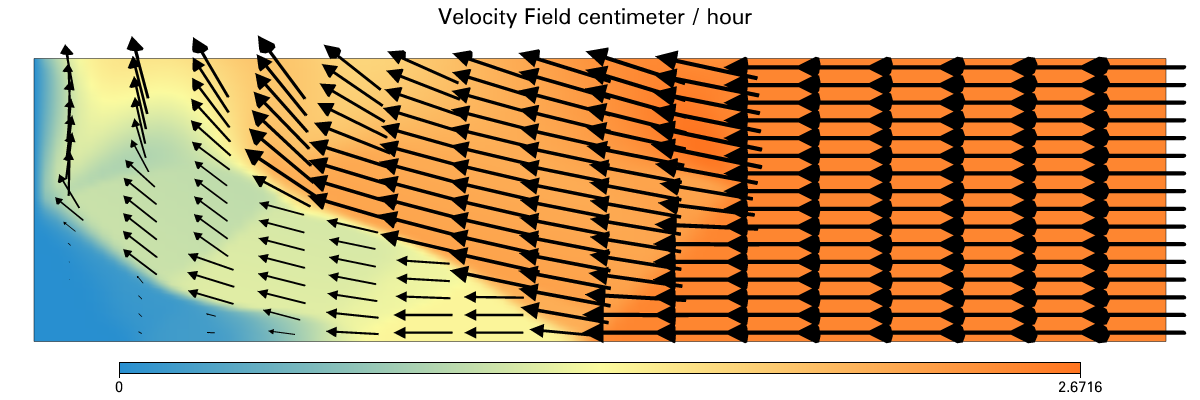

In [33]:
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Surface(Model.swarm, fn.math.dot(Model.velocityField, Model.velocityField))
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()


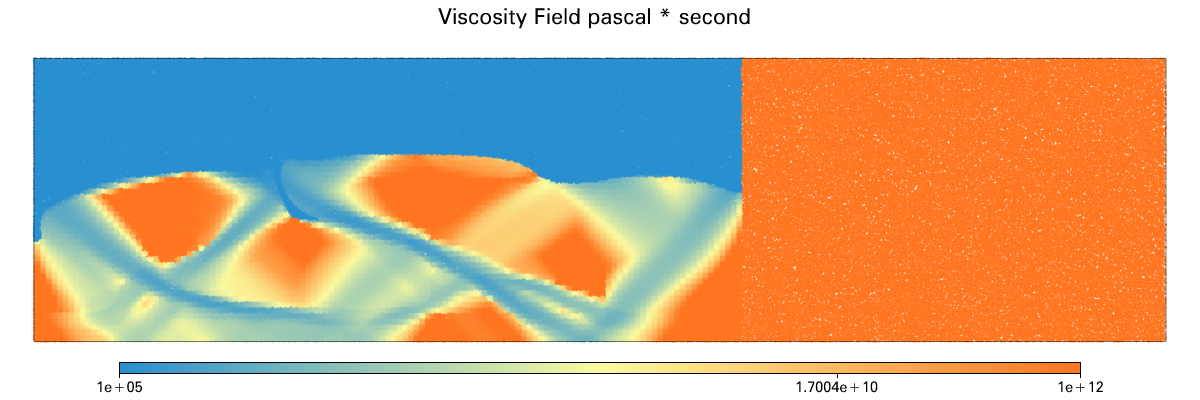

In [34]:
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.viscosityField, logScale=True)
Fig.show()


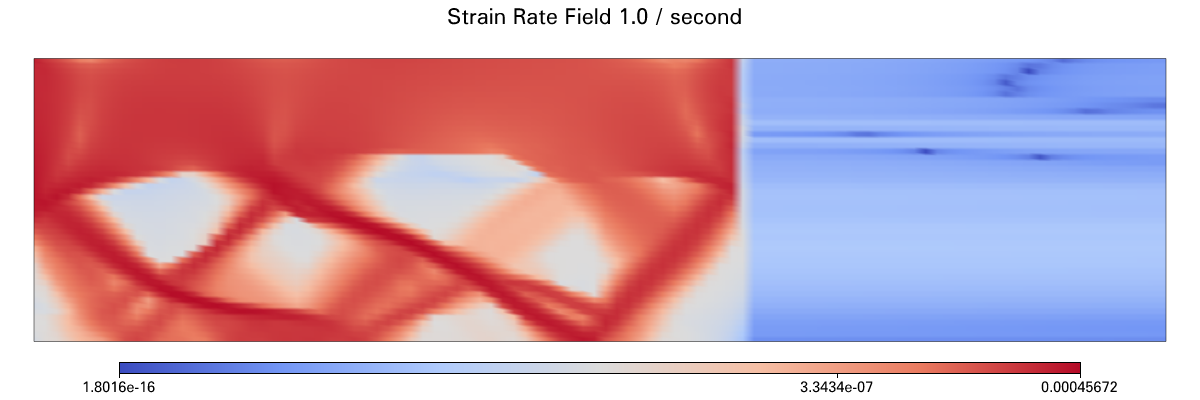

In [35]:
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, Model.strainRateField, logScale=True)
Fig.show()